<a href="https://colab.research.google.com/github/kelvin19-dev/ML/blob/main/Sentiment_Analysis_of_Tweets_Using_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sentiment analysis of Tweets using TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

---

## Introduction

## Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 30.5 MB/s 
     |████████████████████████████████| 243 kB 36.0 MB/s 


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.7.0


## Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
dataset = nlp.load_dataset("emotion")

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train = dataset["train"]
val = dataset["validation"]
test = dataset["test"]

In [6]:
def get_tweet(data):
  tweets = [x["text"] for x in data]
  labels = [x["label"] for x  in data]
  return tweets, labels

In [7]:
tweets, labels = get_tweet(train)

In [8]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Tokenizer

1. Tokenizing the tweets

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token="<UNK>")
tokenizer.fit_on_texts(tweets)

In [11]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [12]:
tweets[0]

'i didnt feel humiliated'

## Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

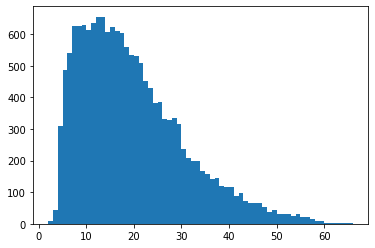

In [13]:
lengths = [len(t.split(" ")) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [14]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating="post", padding="post", maxlen=maxlen)
  return padded


In [16]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [17]:
padded_train_seq[0]


array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [18]:
classes = set(labels)
print(classes)

{'fear', 'joy', 'surprise', 'sadness', 'love', 'anger'}


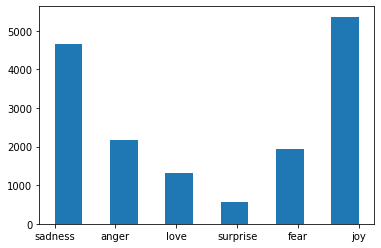

In [19]:
plt.hist(labels, bins=11)
plt.show()

In [20]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [21]:
class_to_index

{'anger': 5, 'fear': 0, 'joy': 1, 'love': 4, 'sadness': 3, 'surprise': 2}

In [22]:
index_to_class

{0: 'fear', 1: 'joy', 2: 'surprise', 3: 'sadness', 4: 'love', 5: 'anger'}

In [23]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [24]:
train_labels = names_to_ids(labels)
print(train_labels[0])

3


## Creating the Model

1. Creating the model
2. Compiling the model

In [25]:
model = tf.keras.models.Sequential([
         tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
         tf.keras.layers.Dense(6, activation="softmax")
])

model.compile(
        loss = "sparse_categorical_crossentropy",
        optimizer= "adam",
        metrics= ["accuracy"]
)

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Training the Model

1. Preparing a validation set
2. Training the model

In [27]:
val_tweets, val_labels = get_tweet(val)
val_seq =  get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [28]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 3)

In [29]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs = 20,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor="Val_accuracy", patience =2)
    ]
)

Epoch 1/20
500/500 [==============================] - 19s 16ms/step - loss: 1.3477 - accuracy: 0.4793 - val_loss: 1.0561 - val_accuracy: 0.6020
Epoch 2/20
500/500 [==============================] - 7s 13ms/step - loss: 0.8064 - accuracy: 0.6999 - val_loss: 0.5727 - val_accuracy: 0.8150
Epoch 3/20
500/500 [==============================] - 7s 13ms/step - loss: 0.3428 - accuracy: 0.8891 - val_loss: 0.4117 - val_accuracy: 0.8590
Epoch 4/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1968 - accuracy: 0.9379 - val_loss: 0.4407 - val_accuracy: 0.8620
Epoch 5/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1465 - accuracy: 0.9534 - val_loss: 0.3721 - val_accuracy: 0.8855
Epoch 6/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1051 - accuracy: 0.9672 - val_loss: 0.3903 - val_accuracy: 0.8815
Epoch 7/20
500/500 [==============================] - 7s 13ms/step - loss: 0.0871 - accuracy: 0.9739 - val_loss: 0.4081 - val_accuracy: 0.882

## Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

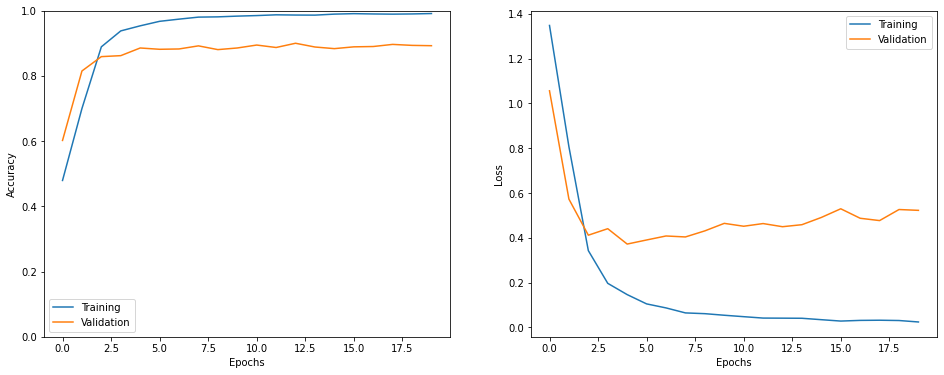

In [30]:
show_history(h)

In [31]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [32]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.5527 - accuracy: 0.8755


In [33]:
i = random.randint(0, len(test_labels) - 1)
print ("Sentence:", test_tweets[i])
print("Emotion:", index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype("uint8")]

Sentence: i feel like im a pathetic little desperation
Emotion: sadness


In [34]:
preds = model.predict(test_seq)
preds = np.argmax(preds, axis=1)



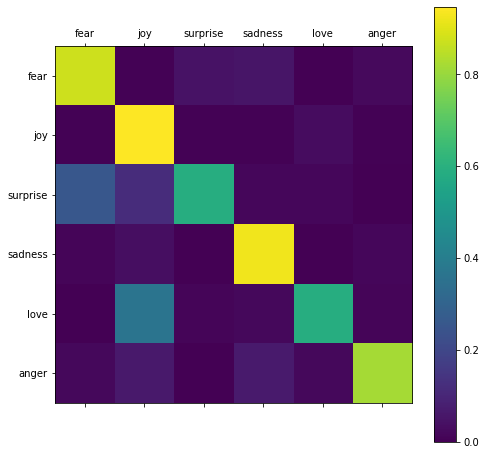

In [35]:
show_confusion_matrix(test_labels, preds, list(classes))